# H&M Fashion Recommendation Dataset

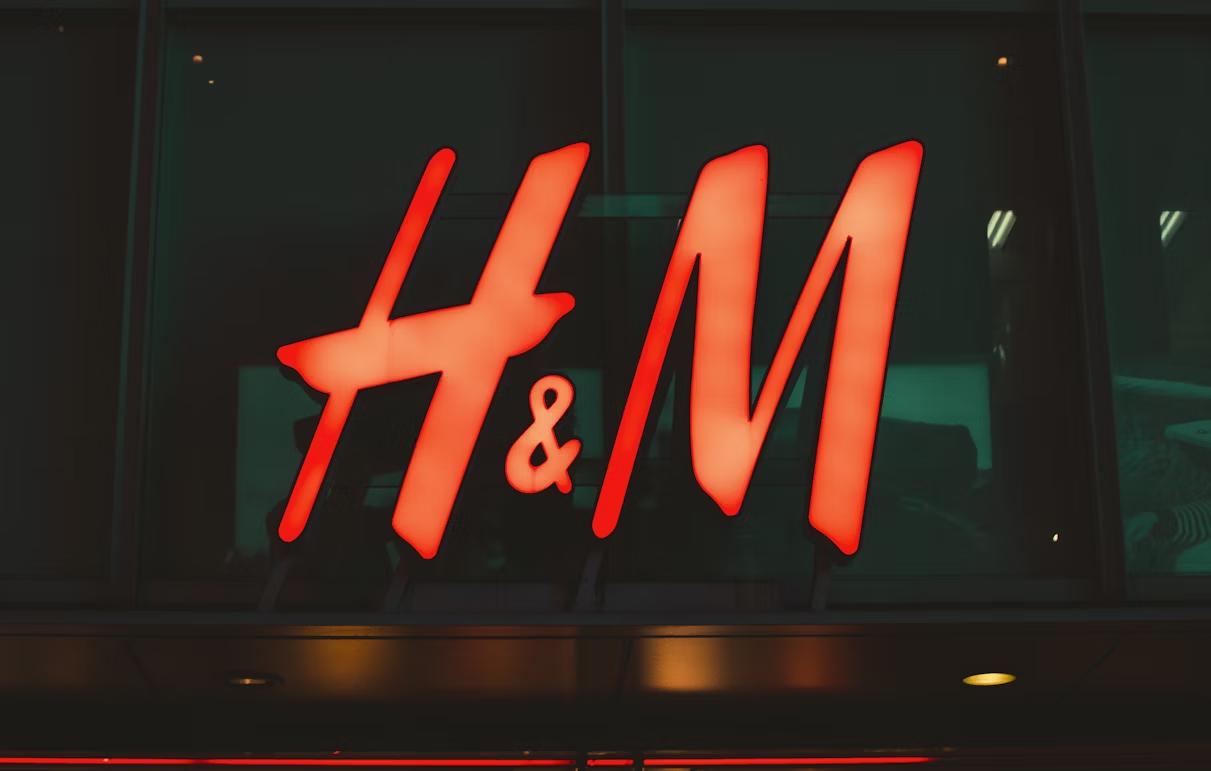


There are 3 main tables:

1. articles - contains informations about each article (like product code, name, product group code, name ...)
2. customers - contains informations about each customer (fidelity card membership, age, postal code)
3. transactions (train)

#### Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import implicit  # for collaborative filtering
from scipy.sparse import csr_matrix
from datetime import datetime

#### Load Dataset (H&M Fashion)

In [3]:
def load_data():
    articles = pd.read_csv('articles.csv')
    customers = pd.read_csv('customers.csv')
    transactions = pd.read_csv('transactions_train.csv')
    return articles, customers, transactions

In [4]:
articles, customers, transactions = load_data()
print("data loaded...")

data loaded...


In [5]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


#### Data Cleaning and Analysis

In [18]:
articles.info()
articles['description'] = articles[['prod_name', 'product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'department_name', 'index_group_name', 'section_name', 'garment_group_name']].agg(' '.join, axis=1)
articles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,description
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,Strap top Vest top Garment Upper body Solid Bl...
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,Strap top Vest top Garment Upper body Solid Wh...
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,Strap top (1) Vest top Garment Upper body Stri...
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",OP T-shirt (Idro) Bra Underwear Solid Black Da...
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",OP T-shirt (Idro) Bra Underwear Solid White Li...


In [19]:
articles['description'] = articles[['description', 'detail_desc']].applymap(str).agg(' '.join, axis=1)
articles.head()

C:\Users\Shubham Gupta\AppData\Local\Temp\ipykernel_5596\1837304747.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  articles['description'] = articles[['description', 'detail_desc']].applymap(str).agg(' '.join, axis=1)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,description
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,Strap top Vest top Garment Upper body Solid Bl...
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,Strap top Vest top Garment Upper body Solid Wh...
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,Strap top (1) Vest top Garment Upper body Stri...
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",OP T-shirt (Idro) Bra Underwear Solid Black Da...
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",OP T-shirt (Idro) Bra Underwear Solid White Li...


In [20]:
articles.to_csv('articles1.csv', index= False)
articles['description'].values[0]

'Strap top Vest top Garment Upper body Solid Black Dark Jersey Basic Ladieswear Womens Everyday Basics Jersey Basic Jersey top with narrow shoulder straps.'

In [22]:
articles = articles[['article_id', 'description']]
articles.head()
articles.to_csv('articles1.csv', index= False)

In [23]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [24]:
transactions = transactions[['customer_id', 'article_id']]
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   customer_id  object
 1   article_id   int64 
dtypes: int64(1), object(1)
memory usage: 485.1+ MB


In [26]:
t = transactions
t['cust'] = t['customer_id'].apply(lambda x: int(x, 16))
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   customer_id  object
 1   article_id   int64 
 2   cust         object
dtypes: int64(1), object(2)
memory usage: 727.6+ MB


C:\Users\Shubham Gupta\AppData\Local\Temp\ipykernel_5596\721150086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['cust'] = t['customer_id'].apply(lambda x: int(x, 16))


In [34]:
type(t['article_id'].values[1])
t = t[['customer_id', 'article_id']]
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   customer_id  object
 1   article_id   int64 
dtypes: int64(1), object(1)
memory usage: 485.1+ MB


In [36]:
transactions = t
transactions.info()
transactions.to_csv('transactions1.csv', index= False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   customer_id  object
 1   article_id   int64 
dtypes: int64(1), object(1)
memory usage: 485.1+ MB


In [43]:
len(transactions['customer_id'].unique())

1362281

In [38]:
t.shape

(31788324, 2)

In [46]:
t = t.iloc[:5788324]
len(t['customer_id'].unique())

655479

#### Creation of Customer Purchases (~6.5 lakh customers and ~1 lakh products)

In [47]:
## work on t as transactions for safety
customer_purchases = t.groupby('customer_id')['article_id'].apply(list).reset_index()
print(customer_purchases)

                                              customer_id  \
0       9475862015264971221248214828904923560602285253...   
1       4571059672841539163133048279594898115151983489...   
2       6116990065284462810764946559699987067290722768...   
3       6907096570081916088869556412363544629881804361...   
4       8639559392216894130813047803836240585733025821...   
...                                                   ...   
655474  1157913136213245282395205268929181627988759928...   
655475  1157914442702647681658303862867247343543433829...   
655476  1157915367623317568061324705754530426946744791...   
655477  1157917394124884238554816054251587488954129539...   
655478  1157917524959165373255961370315423330732502964...   

                                               article_id  
0                       [625548001, 176209023, 627759010]  
1       [583558001, 639677008, 640244003, 521269001, 6...  
2                       [663713001, 541518023, 663713001]  
3                          

In [86]:
customer_purchases['article_id'][50201]

[640622002, 632143002, 681247002, 621757003, 616088001, 584483002, 616086001]

In [87]:
customer_purchases['customer_id'][50201]

8840288584845662124197493287858715390608602251855650309925873848457242020837

#### Feature Engineering and Vectorization

In [49]:
# Convert descriptions to TF-IDF vectors
vectorizer = TfidfVectorizer()
article_vectors = vectorizer.fit_transform(articles['description'])

# Store product vectors and ID mappings
article_id_to_vector = {}
for index, row in articles.iterrows():
    article_id_to_vector[row['article_id']] = article_vectors[index]

In [90]:
print(article_vectors)

  (0, 13236)	0.21673788895691978
  (0, 12514)	0.20299054454303356
  (0, 9712)	0.20406363956897494
  (0, 15105)	0.06692253828038769
  (0, 1983)	0.2086777133241429
  (0, 5176)	0.2172183503630135
  (0, 15121)	0.13430352940272777
  (0, 7979)	0.12390454161416922
  (0, 1982)	0.42342897609452307
  (0, 7311)	0.3711230631490766
  (0, 4253)	0.11132239809228708
  (0, 2323)	0.1590288354041786
  (0, 12899)	0.10823429848068693
  (0, 2432)	0.08322065035733951
  (0, 14487)	0.11928848830679062
  (0, 5947)	0.08337578834780437
  (0, 14639)	0.27765365039338546
  (0, 14051)	0.43092163276229145
  (0, 13230)	0.2902844754284237
  (1, 8278)	0.1230657436397005
  (1, 14985)	0.19570451993882412
  (1, 13236)	0.21495549531073282
  (1, 12514)	0.20132120533072145
  (1, 9712)	0.20238547551406055
  (1, 15105)	0.06637218546671156
  :	:
  (105541, 8675)	0.16546276810953914
  (105541, 8181)	0.1351804535152949
  (105541, 5280)	0.10082349492777713
  (105541, 11574)	0.14525931323448352
  (105541, 12714)	0.09442763694383306
 

In [58]:
article_id_to_vector

{108775015: <1x15401 sparse matrix of type '<class 'numpy.float64'>'
 	with 19 stored elements in Compressed Sparse Row format>,
 108775044: <1x15401 sparse matrix of type '<class 'numpy.float64'>'
 	with 19 stored elements in Compressed Sparse Row format>,
 108775051: <1x15401 sparse matrix of type '<class 'numpy.float64'>'
 	with 21 stored elements in Compressed Sparse Row format>,
 110065001: <1x15401 sparse matrix of type '<class 'numpy.float64'>'
 	with 44 stored elements in Compressed Sparse Row format>,
 110065002: <1x15401 sparse matrix of type '<class 'numpy.float64'>'
 	with 44 stored elements in Compressed Sparse Row format>,
 110065011: <1x15401 sparse matrix of type '<class 'numpy.float64'>'
 	with 45 stored elements in Compressed Sparse Row format>,
 111565001: <1x15401 sparse matrix of type '<class 'numpy.float64'>'
 	with 30 stored elements in Compressed Sparse Row format>,
 111565003: <1x15401 sparse matrix of type '<class 'numpy.float64'>'
 	with 30 stored elements in

#### Creation of User Profile

In [67]:
from scipy.sparse import vstack

def compute_user_profile(customer_id, customer_purchases, article_id_to_vector):
    # Find the user's purchased products
    purchased_products = customer_purchases.loc[customer_purchases['customer_id'] == customer_id, 'article_id'].values
    if len(purchased_products) == 0:
        return None
    
    # Aggregate product vectors
    purchased_vectors = [article_id_to_vector[pid] for pid in purchased_products[0] if pid in article_id_to_vector]
    if not purchased_vectors:
        return None
    
    user_profile = np.asarray(vstack(purchased_vectors).mean(axis=0)).flatten()
    return user_profile

# Example usage
customer_id = 94758620152649712212482148289049235606022852530951495265820112960079447
user_profile = compute_user_profile(customer_id, customer_purchases, article_id_to_vector)


#### Recommendation Engine

In [74]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_products(user_profile, article_vectors, articles, interacted_product_ids, top_n = 5):
    if user_profile is None:
        return []
    
    user_profile = np.asarray(user_profile).reshape(1, -1)
    
    # Compute similarity between the user profile and all product vectors
    all_product_ids = articles['article_id'].values
    all_product_vectors = [article_id_to_vector[pid] for pid in all_product_ids if pid not in interacted_product_ids]
    all_product_ids_filtered = [pid for pid in all_product_ids if pid not in interacted_product_ids]
    
    if not all_product_vectors:
        return []

    all_product_vectors_matrix = np.asarray(vstack(all_product_vectors).todense())
    similarities = cosine_similarity(user_profile, all_product_vectors_matrix).flatten()
    
    # Get top-N recommendations
    top_n_indices = np.argsort(similarities)[::-1]
    recommended_product_ids = [all_product_ids_filtered[i] for i in top_n_indices][0:top_n]
    
    return recommended_product_ids

# Example usage
interacted_product_ids = customer_purchases.loc[customer_purchases['customer_id'] == customer_id, 'article_id'].values[0]
recommended_product_ids = recommend_products(user_profile, article_vectors, articles, interacted_product_ids)
print("Recommended products for user:", recommended_product_ids)

Recommended products for user: [666448007, 666448009, 666448001, 666448005, 666448004]


#### Example Run on different customers

In [88]:
customer_id = 8840288584845662124197493287858715390608602251855650309925873848457242020837
user_profile = compute_user_profile(customer_id, customer_purchases, article_id_to_vector)
interacted_product_ids = customer_purchases.loc[customer_purchases['customer_id'] == customer_id, 'article_id'].values[0]
recommended_product_ids = recommend_products(user_profile, article_vectors, articles, interacted_product_ids, top_n = 7)
print("Recommended products for user:", recommended_product_ids)

Recommended products for user: [616088002, 616086002, 616088013, 616086008, 726938001, 726938003, 506183001]


In [77]:
customer_id = 863955939221689413081304780383624058573302582145729654331945563981958338
user_profile = compute_user_profile(customer_id, customer_purchases, article_id_to_vector)
interacted_product_ids = customer_purchases.loc[customer_purchases['customer_id'] == customer_id, 'article_id'].values[0]
recommended_product_ids = recommend_products(user_profile, article_vectors, articles, interacted_product_ids, top_n = 7)
print("Recommended products for user:", recommended_product_ids)

Recommended products for user: [656213003, 647373002, 788844001, 455832001, 802529001, 647373004, 669804002]


In [83]:
customer_id = 2222447285218602695311117946796036375620481439427532238505999312640706666
user_profile = compute_user_profile(customer_id, customer_purchases, article_id_to_vector)
interacted_product_ids = customer_purchases.loc[customer_purchases['customer_id'] == customer_id, 'article_id'].values[0]
recommended_product_ids = recommend_products(user_profile, article_vectors, articles, interacted_product_ids, top_n = 7)
print("Recommended products for user:", recommended_product_ids)

Recommended products for user: [617249026, 617249009, 617249010, 617249016, 617249004, 617249033, 617249007]
